In [1]:
import hmftpy as hmf
from hmftpy.plaquettes.triangular import plaq12, plaq12z, plaq9p, plaq9d, plaq3
from hmftpy.operators import mf_ops, inner_hamiltonian, periodic_hamiltonian
from hmftpy import do_hmft
from hmftpy.hmf import get_mfs
from hmftpy.plot_spins import draw_tri_lattice, draw_cluster, plot_spins
from quspin.basis import spin_basis_1d
from quspin.operators import quantum_operator
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

plaq = plaq12
L = plaq['L']
basis = spin_basis_1d(L, pauli=0)

ops = hmf.operators.mf_ops(plaq, basis)
maxit=50

def ni_op(plaq, basis):
    A, B, C = plaq['n_nearest_sublattice']
    a_op = quantum_operator({'static': [['x', [[1/len(A), j] for j in A]]]}, basis=basis, check_symm=False, check_herm=False)
    b_op = quantum_operator({'static': [['x', [[-0.5/len(B), j] for j in B]],
                                        ['y', [[0.5*np.sqrt(3)/len(B), j] for j in B]]]}, basis=basis, check_symm=False, check_herm=False)
    c_op = quantum_operator({'static': [['x', [[-0.5/len(C), j] for j in C]],
                                        ['y', [[-0.5*np.sqrt(3)/len(C), j] for j in C]]]}, basis=basis, check_symm=False, check_herm=False)
    return a_op + b_op + c_op

m_op = ni_op(plaq, basis)

In [2]:
steps = 30
l = 3
alphas = np.linspace(0, 1, l)
print(alphas)
energies = np.zeros((l, steps))
Nis = np.zeros((l, steps))
Ni2s = np.zeros((l, steps))

J2s = np.linspace(-.25, 0.15, steps)
mf0s = [None for i in range(l)]

def couplings(J2, alpha=0):
    interactions = {'local': {},
                    'nearest': {'xx': 1, 'yy': 1, 'zz': alpha},
                    'n_nearest': {'xx': J2, 'yy': J2, 'zz': alpha*J2},
                    'n_n_nearest': {}}
    return interactions

[0.  0.5 1. ]


In [5]:
steps=40
energies2 = np.zeros((l, steps))

J2s2 = np.linspace(.9, .2, steps)
mf0s2 = [None for i in range(l)]

for i, J2 in enumerate(tqdm(J2s2, ascii=True)):
    for j, alpha in enumerate(alphas):
        interactions = couplings(J2, alpha)
        energies2[j,i], v, mf0, cvg = do_hmft(plaq, interactions, basis, 
                                                max_iter=maxit, mf0=mf0s2[j],
                                                ops=ops,
                                                mf_cvg=False, every_other=True, hmft_tol=10**-10)
        # if i == 0:
        #     mf0s2[j] = mf0

100%|##########| 40/40 [11:52<00:00, 17.81s/it]


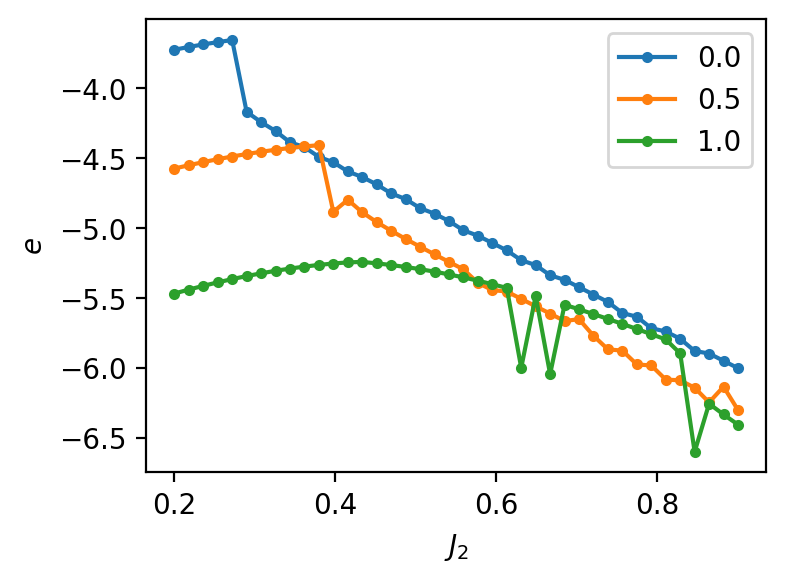

In [6]:
plt.figure(figsize=(4,3), dpi=200)
for j, alpha in enumerate(alphas):
    plt.plot(J2s2, energies2[j,:], label=np.round(alpha, 2), marker='.')
plt.legend()
plt.xlabel('$J_2$')
plt.ylabel('$e$')
plt.show()

In [3]:
for i, J2 in enumerate(tqdm(J2s, ascii=True)):
    for j, alpha in enumerate(alphas):
        interactions = couplings(J2, alpha)
        energies[j,i], v, mf0s[j], cvg = do_hmft(plaq, interactions, basis, 
                                                max_iter=maxit, mf0=mf0s[j],
                                                ops=ops,
                                                mf_cvg=False, every_other=True, hmft_tol=10**-10)
        Nis[j,i] = np.real(m_op.matrix_ele(v, v))
        Ni2s[j,i] = np.real(m_op.matrix_ele(v, m_op.dot(v)))

100%|##########| 30/30 [07:24<00:00, 14.83s/it]


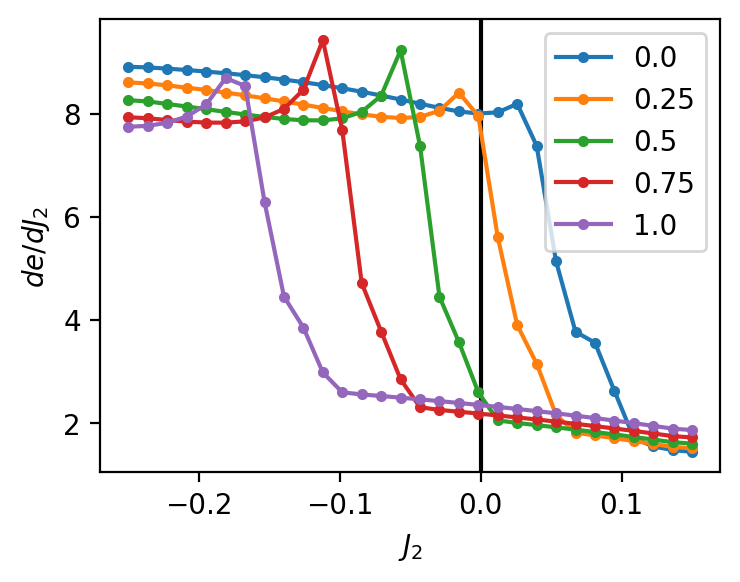

In [4]:
plt.figure(figsize=(4,3), dpi=200)
plt.axvline(0, color='black')
for j, alpha in enumerate(alphas):
    plt.plot(J2s, np.gradient(energies[j,:], J2s), label=np.round(alpha, 2), marker='.')
plt.legend()
plt.xlabel('$J_2$')
plt.ylabel('$de/dJ_2$')
plt.show()